# Basic tutorial: ``Interleaving`` class

This class encodes all the information needed to figure out an interleaving between two ``MapperGraph`` instances. 


In [1]:
from cereeberus import ReebGraph, MapperGraph, Interleave, Assignment
import cereeberus.data.ex_mappergraphs as ex_mg

import matplotlib.pyplot as plt

## Finding the best bound for interleaving 

TODO: Start by showing the simple version with the `Interleave` class that spits out a bound. Then the second bit is all the details for the curious 

In [2]:
# Pick a pair of example MapperGraphs to interleave 
# Give the bound 
# Show that we can look at the maps in the result 


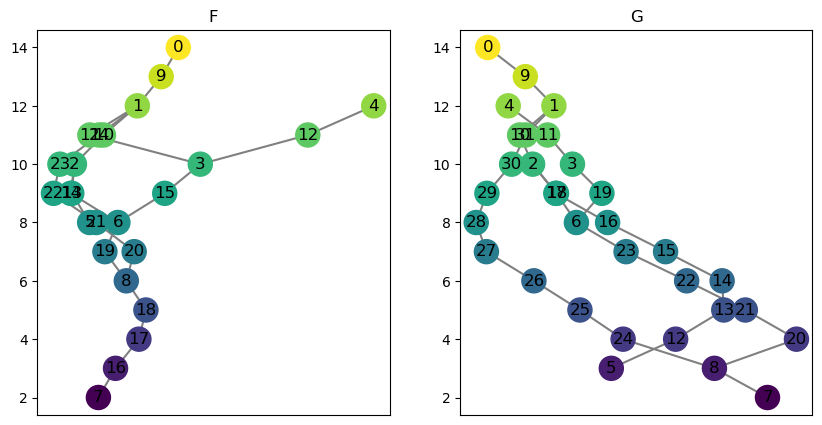

In [3]:
# Going back to these examples 
F = ex_mg.interleave_example_A()
G = ex_mg.interleave_example_B()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
F.draw(ax = ax[0])
ax[0].set_title('F')
G.draw(ax = ax[1])
ax[1].set_title('G');


In [4]:
# myInt = Interleave(F, G, n = 2, initialize_random_maps=True, seed = 17)

# print('Loss before optimization: ', myInt.loss())

TODO: Finish writing this tutorial! 

## The `Assignment` class 

For those interested in understanding how the internal structure works, this tutorial will go through the structures used to encode a given assignment between two input mapper graphs, and then how the ILP optimization functions to find a best choice of assignment. However, the user doesn't need to directly interact with this aspect if the only goal is to get an optimal bound. 

We start with two example Mapper graphs.

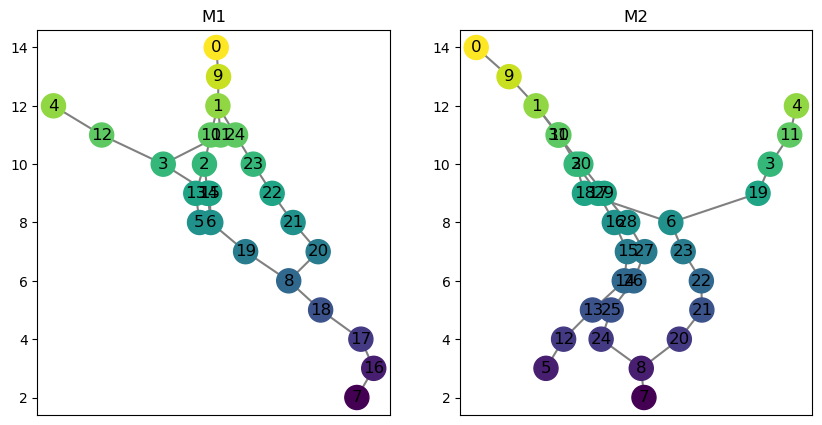

In [5]:
M1 = ex_mg.interleave_example_A()
M2 = ex_mg.interleave_example_B()

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey = True)

M1.draw(ax = ax[0])
ax[0].set_title("M1")
M2.draw(ax = ax[1])
ax[1].set_title("M2");

We can create an instance of the `Assignment` class for a fixed choice of $n$ to store all the relevant matrices and smoothed graphs. 

In [6]:
myAssgn = Assignment(M1, M2, n = 1)

Inside the `Assignment` class, we have lots of setup data ready to go. 

Internally, the two graphs are labeled as $F$ and $G$, and an assignment itself is a collection of four maps: 
- $\phi:F \to G^n$
- $\phi_n:F^n \to G^{2n}$
- $\psi: G \to F^n$. 
- $\psi_n: G^n \to F^{2n}$. 

First we have the two original graphs stored as follows. The $F$ graphs for $0$, $n$, and $2n$ can be called with the function `myAssgn.F(key)` with key in the set `['0','n','2n']`. (Note the `0` is a string, not an integer).

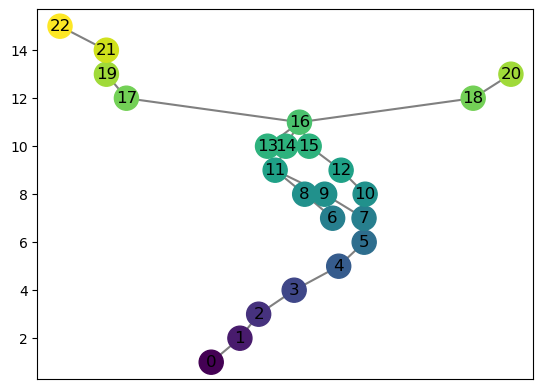

In [7]:
Fn = myAssgn.F('n')
Fn.draw()

In [8]:
for key in ['0', 'n', '2n']:
    print(f"F_{key}: {myAssgn.F(key).summary()}")

F_0: {'nodes': 25, 'edges': 26}
F_n: {'nodes': 23, 'edges': 24}
F_2n: {'nodes': 22, 'edges': 22}


Similarly, we have a function to get the $G$ graphs. 

In [9]:
for key in ['0', 'n', '2n']:
    print(f"G_{key}: {myAssgn.G(key).summary()}")

G_0: {'nodes': 32, 'edges': 32}
G_n: {'nodes': 32, 'edges': 32}
G_2n: {'nodes': 32, 'edges': 32}


All the graphs can be drawn at once with the following command.

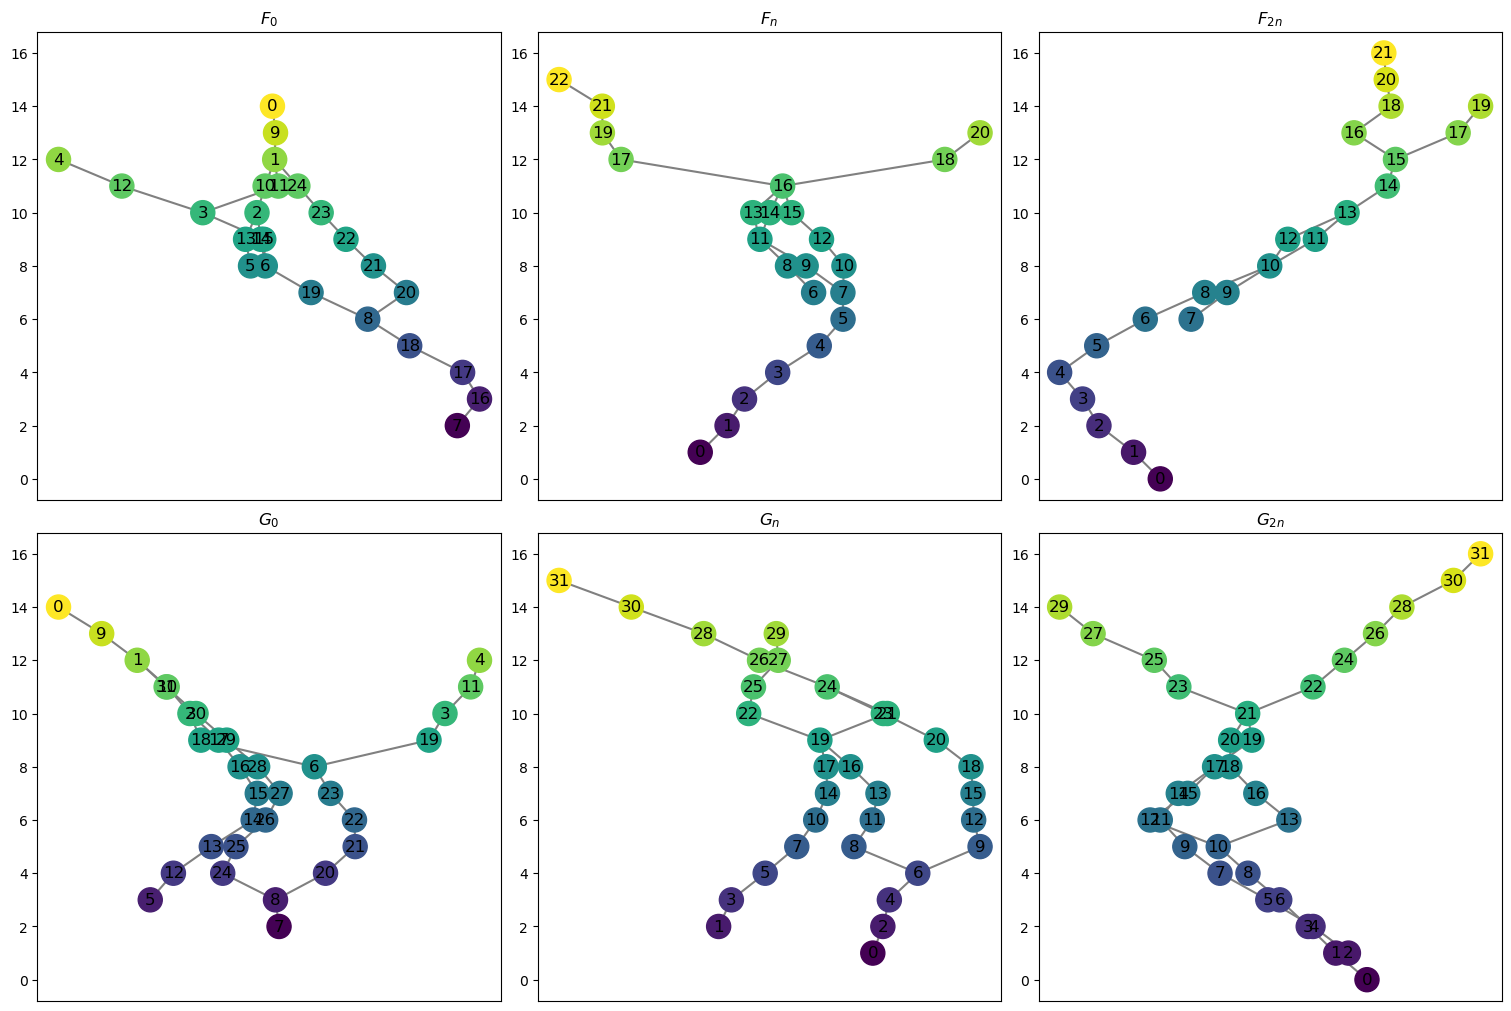

In [10]:
myAssgn.draw_all_graphs();

### Input Matrices 

There are many matrices stored in the `Interleave` class, but since these are largely block matrices due to the function preserving restriction on the maps, we store these in the following structure. See [the labeled blocks documentation](../modules/distance/labeled_blocks.rst) for additional details.

A block dictionary is a dictionary with keys as the integer function values for the relevant graphs. Each key $i$ maps to another dictionary with keys
- `array`: the matrix for the $i$ th block
- `rows`: A list of the vertices (or edges) in order represented in the rows of the matrix
- `cols`: A list of the vertices (or edges) in order represented in the rows of the matrix. 

#### Inclusion Matrices
The first block matrices are the inclusion matrices, which can be accessed by calling `myAssgn.I`. These matrices give the maps $F \to F_n \to F_{2n}$ and $G \to G_n \to G_{2n}$, with entry $M[a,b]=1$ meaning that object $b$ in the input space goes to object $a$ in the output space. 

In [11]:
# For example, the induced inclusion map from $G$ to $G_{n}$ for the vertices is given by:
myAssgn.I('G','n','V')

# The block of the diagram sending vertices with function value 7 in $V(F_n)$ to vertices with value 7 in $V(F_{2n})$ is given by:
myAssgn.I('F','n','V')[7]

LabeledMatrix(
array=
[[0. 1.]
 [1. 0.]], 
rows=[8, 9], 
cols=[6, 7])

Reading the output above, we see that vertex 6 in $F_n$ is sent to vertex $8$ in $F_{2n}$, while vertex 7 in $F_n$ is sent to vertex $9$ in $F_{2n}$

Each map is stored as a `LabeledBlockMatrix` type. See [the documentation](../modules/distance/labeled_blocks.rst) for further details. The full matrix with all the blocks in place can be accessed as follows. 

In [12]:
myAssgn.I('G','n','V').to_labeled_matrix()

LabeledMatrix(
array=
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]], 
rows=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], 
cols=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

And for visualizing, we can use the draw function to plot the matrix with rows and columns labeled accordingly. The `filltype = 'nan'` part makes the drawing function include anything outside the blocks as white, making the block structure easier to visualize.  

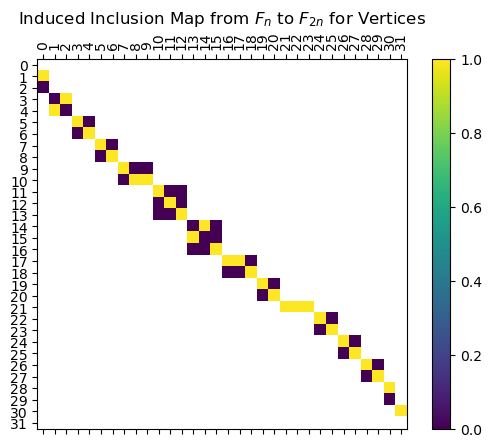

In [13]:
myAssgn.I('G','n','V').draw(filltype = 'nan', colorbar = True);
plt.title(r'Induced Inclusion Map from $F_n$ to $F_{2n}$ for Vertices');

We also have the induced maps for edges. This can be found as follows, or the full matrix can be drawn directly using the `draw_I` command. Note that the third entry for edge labels comes from the `nx.MultiDiGraph` parent class. 

LabeledMatrix(
array=
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]], 
rows=[(14, 17, 0), (15, 17, 0), (16, 18, 0)], 
cols=[(13, 16, 0), (14, 17, 0), (15, 18, 0)])


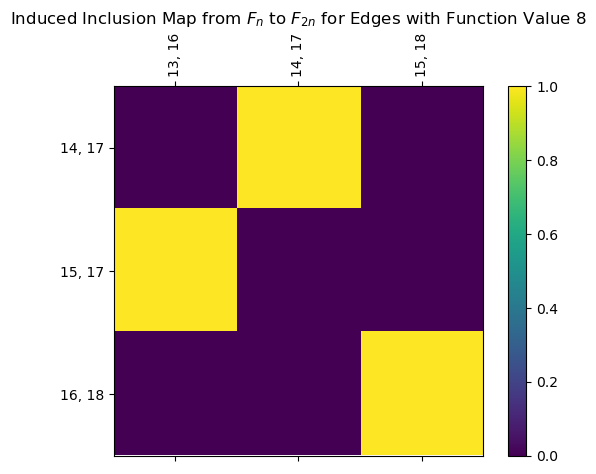

In [14]:
print(myAssgn.I('G','n','E')[7])

myAssgn.I('G','n','E')[7].draw(colorbar = True)
plt.title(r'Induced Inclusion Map from $F_n$ to $F_{2n}$ for Edges with Function Value 8');

There are also commands to draw individual $I$ maps using the `.draw_I` function, as well as the command shown below which draws all the $I$ matrices at once for convenience. 

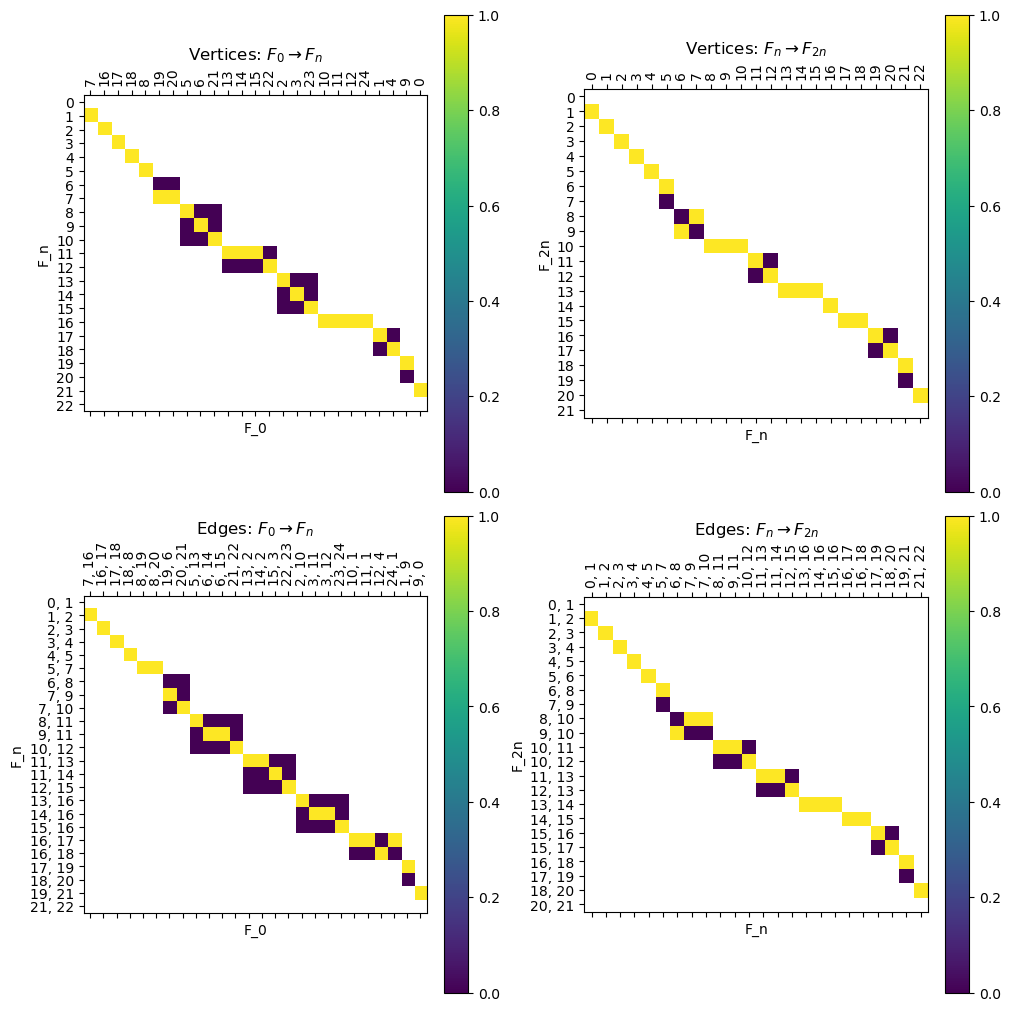

In [15]:
myAssgn.draw_all_I(filltype = 'nan', colorbar = True);

Note that we can get the composition of the maps for $F \Rightarrow F_{2n}$ or $G \Rightarrow G_{2n}$ by matrix multiplication. 

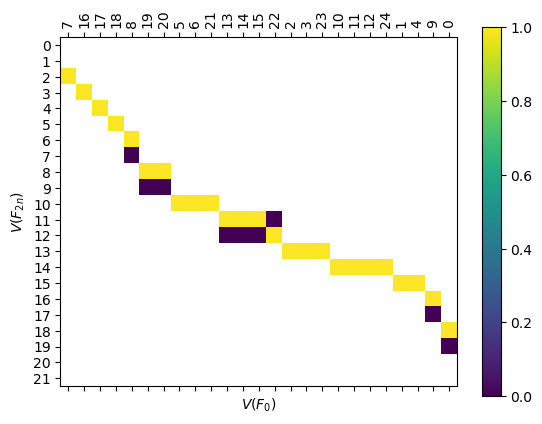

In [16]:
compI = myAssgn.I('F','n','V') @ myAssgn.I('F','0','V')
fig, ax = plt.subplots()
compI.draw(filltype = 'nan', colorbar = True, ax = ax)
ax.set_xlabel(r'$V(F_{0})$')
ax.set_ylabel(r'$V(F_{2n})$');

#### Boundary Matrices

We also have boundary matrices for each graph, where $B[v,e] = 1$ iff $v$ is a vertex of edge $e$. 

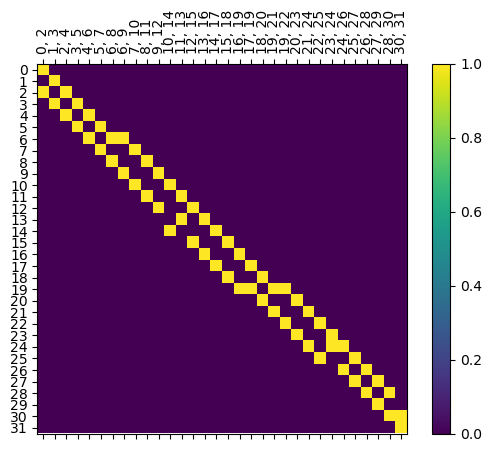

In [17]:
myAssgn.B('G','n').draw(colorbar = True);

Note that unlike the inclusion matrices, this matrix doesn't have nice block structure. In particular, if an edge is at height $i$, it's endpoints are at heights $i$ and $i+1$. However, we can pull out the two pieces of the boundary matrix to use, and these are stored as `LabeledBlockMatrix` types. 

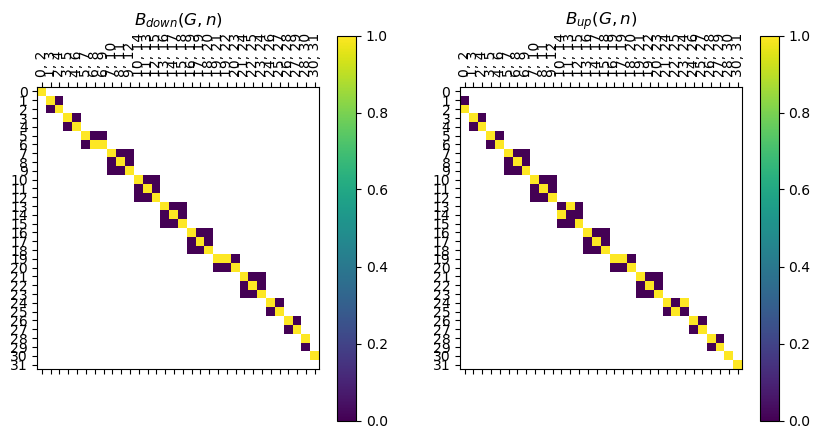

In [18]:
B_down = myAssgn.B_down('G','n')
B_up = myAssgn.B_up('G','n')

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
B_down.draw(filltype = 'nan', colorbar = True, ax = ax[0])
ax[0].set_title(r'$B_{down}(G,n)$')
B_up.draw(filltype = 'nan', colorbar = True, ax = ax[1])
ax[1].set_title(r'$B_{up}(G,n)$');

Note that block `i` for the `B_up` matrix has edges with height `i` since they are stored as the lower of the two function values of the endpoints; and vertices with height `i+1`

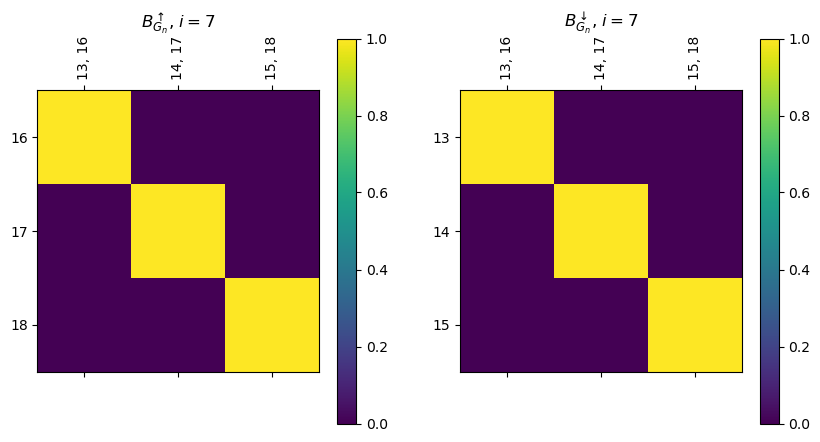

In [19]:
fix, ax = plt.subplots(1, 2, figsize=(10, 5))
myAssgn.B_up('G', 'n')[7].draw(colorbar = True, ax = ax[0])
ax[0].set_title(r'$B^{\uparrow}_{G_n}$, $i=7$')
myAssgn.B_down('G', 'n')[7].draw(colorbar = True, ax = ax[1])
ax[1].set_title(r'$B^{\downarrow}_{G_n}$, $i=7$');

We also have a drawing command, `.draw_B` to simplify the process, and `.draw_all_B` to show them all at once.

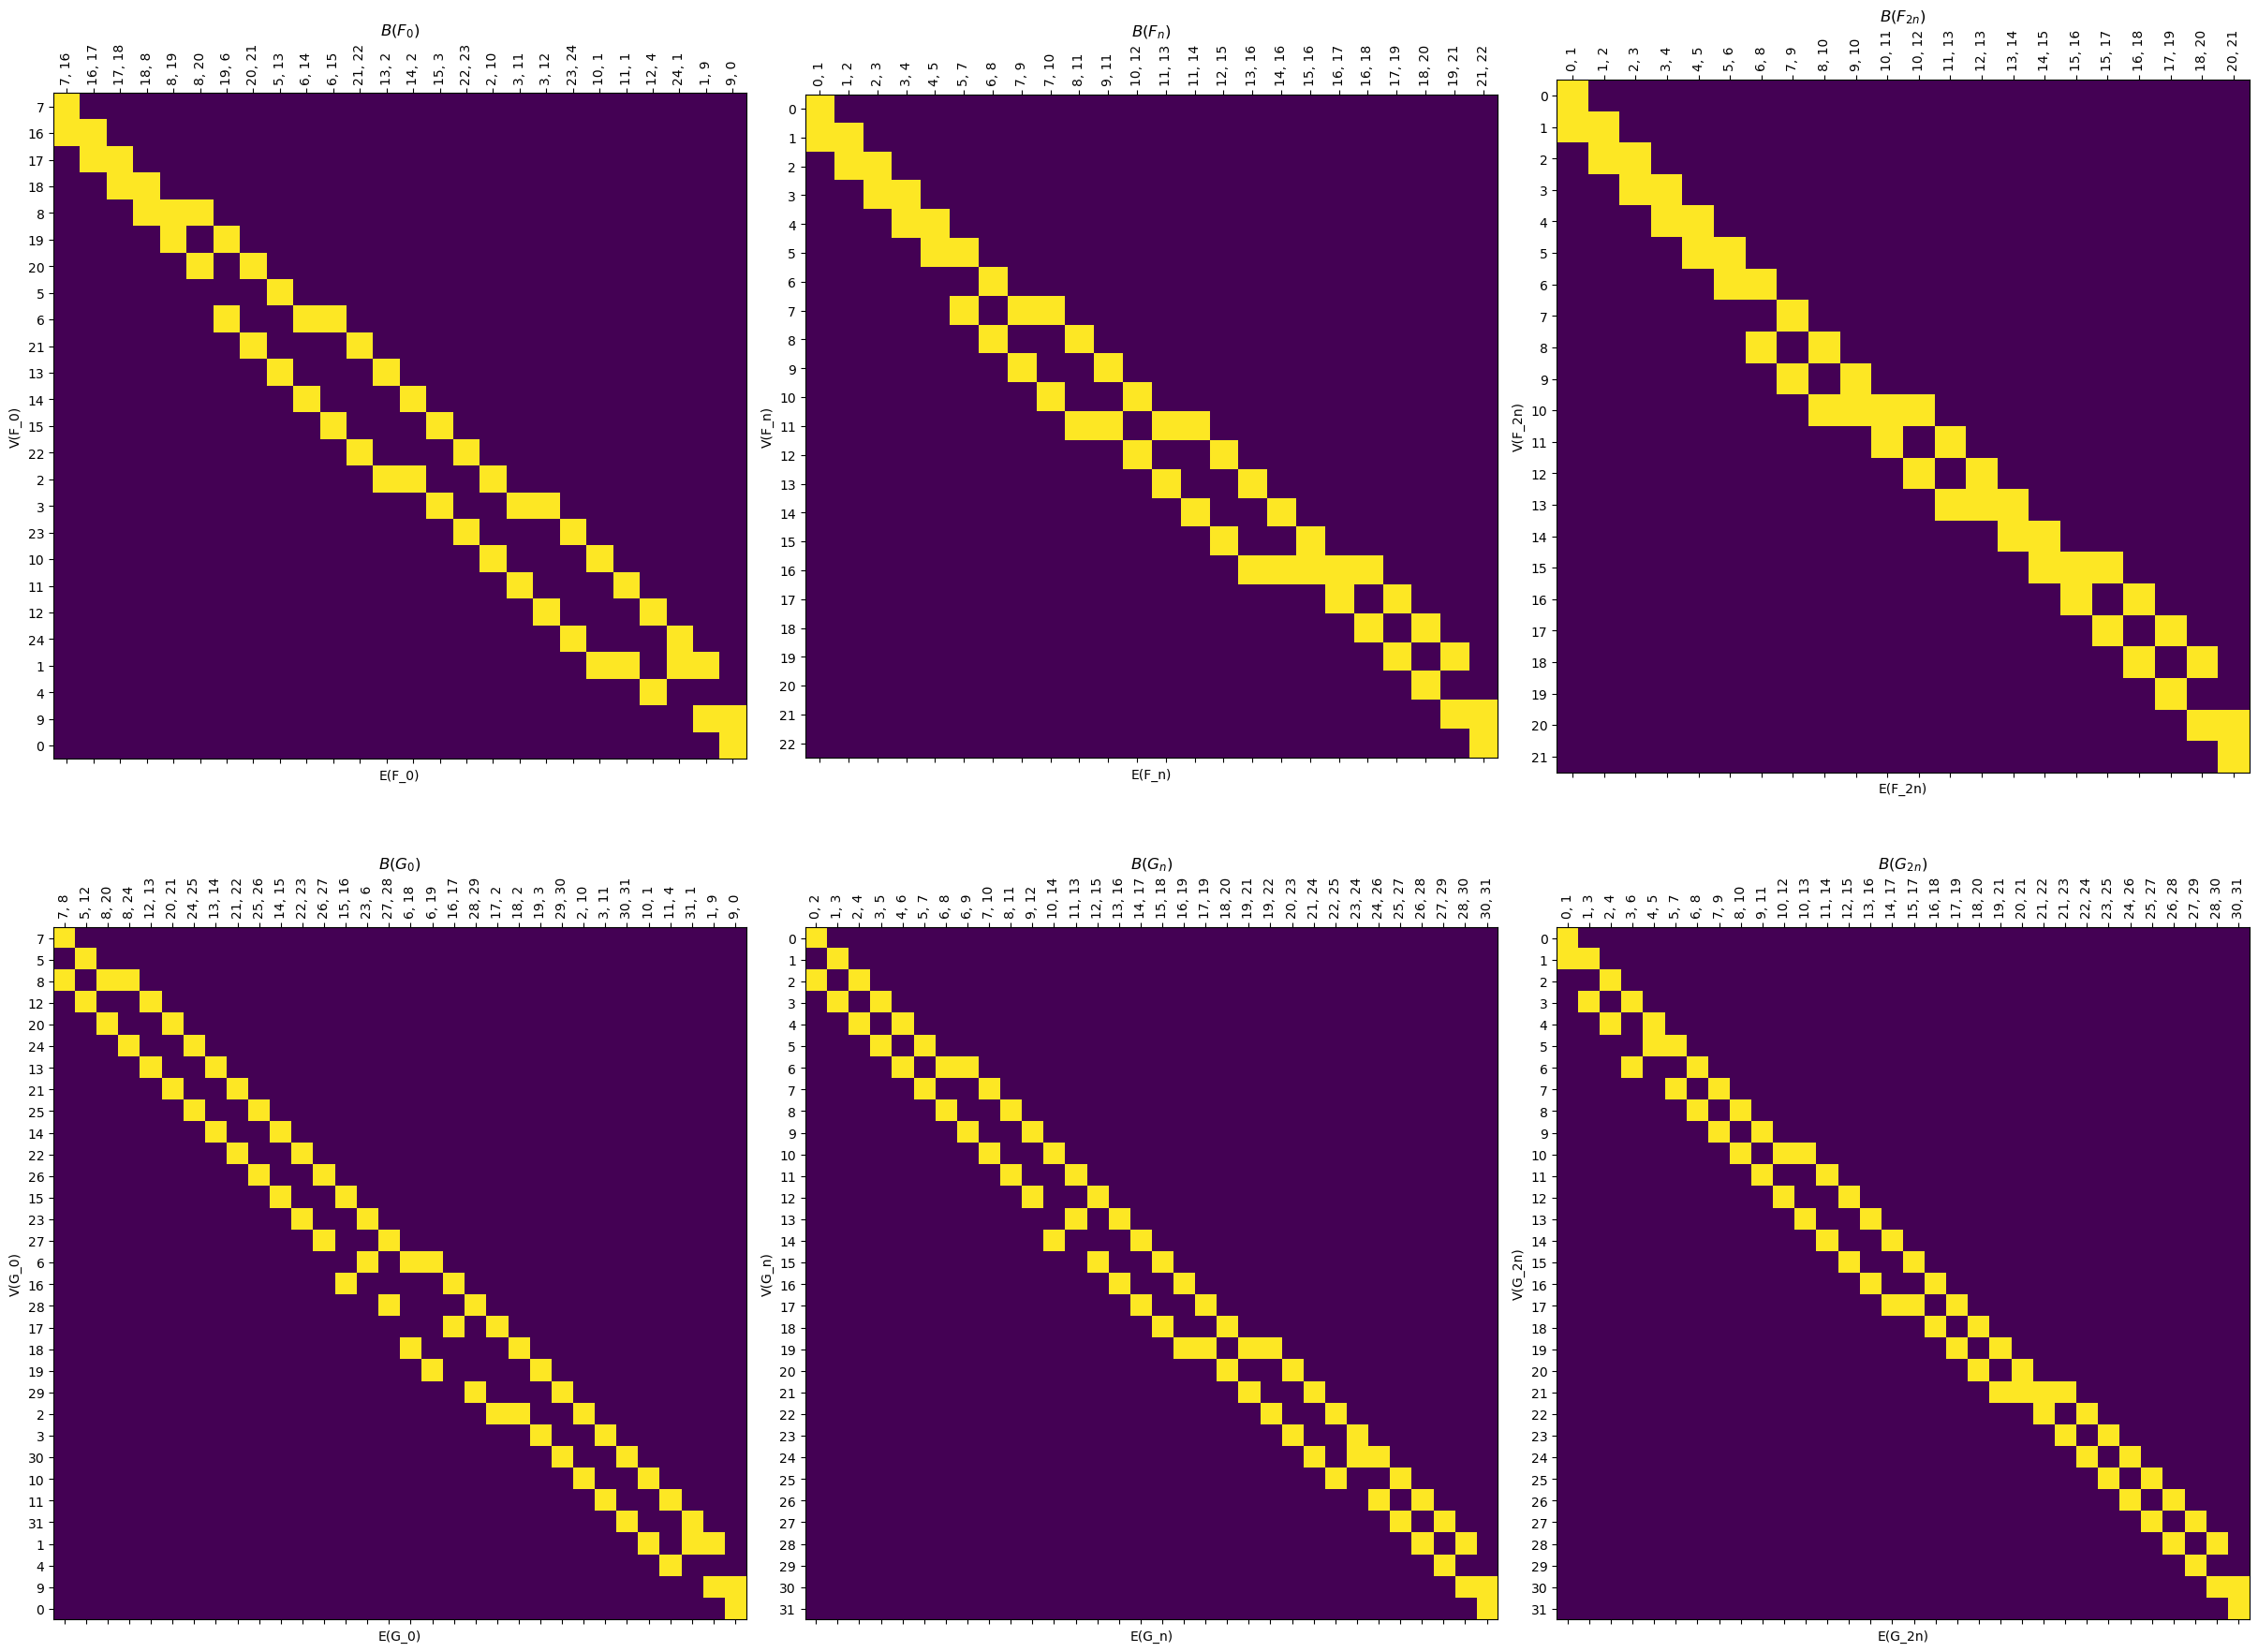

In [20]:
myAssgn.draw_all_B();

#### Distance matrix 

Following (our paper that we will cite once it's on the arxiv TODO), there is a distance between any vertices at the same level defined to be the amount of smoothing needed for the two vertices to be mapped to the same vertex. This block matrix is stored in `Interleave.D`. 

In [21]:
# Here's the distance between the vertices at function value 9 in $F$
print(myAssgn.D('F','0','V')[9])

LabeledMatrix(
array=
[[0. 1. 1. 3.]
 [1. 0. 1. 3.]
 [1. 1. 0. 3.]
 [3. 3. 3. 0.]], 
rows=[13, 14, 15, 22], 
cols=[13, 14, 15, 22])


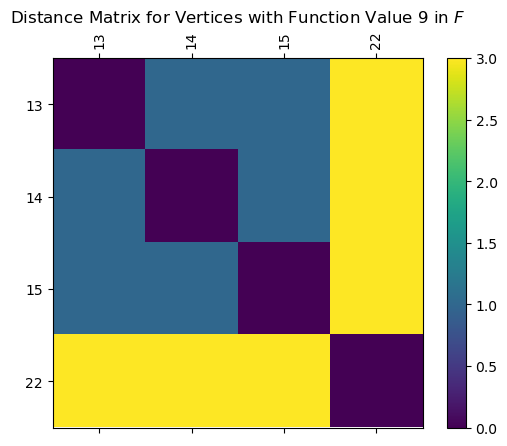

In [22]:
# and here's a visual for the same distance matrix
myAssgn.D('F','0','V')[9].draw(colorbar=True)
plt.title(r'Distance Matrix for Vertices with Function Value 9 in $F$');

As before, we can easily draw the full distance matrix using the `draw_D` command. Here's the full matrix for $G_{n}$.

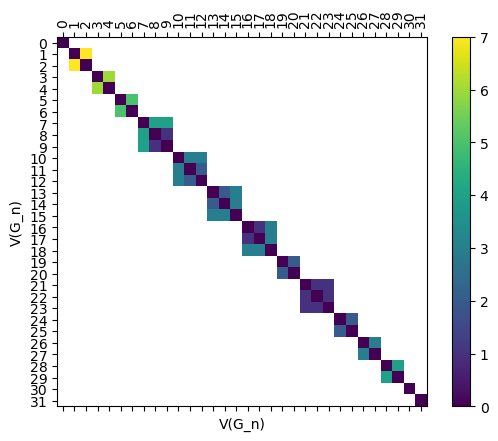

In [23]:
myAssgn.draw_D('G', 'n','V', filltype='nan', colorbar=True); 

Here's an edge version too. 

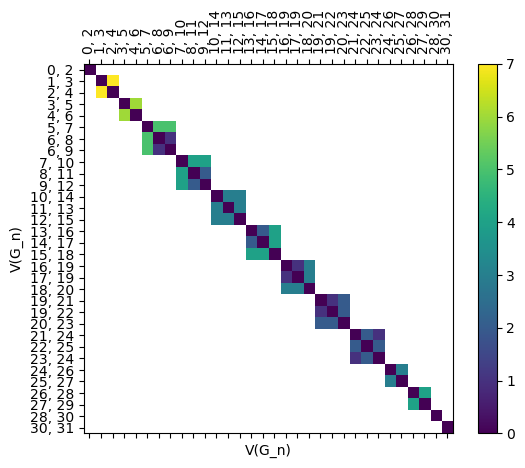

In [24]:
myAssgn.draw_D('G', 'n','E', filltype = 'nan');

#### The assignment matrices

Next well show the storage of the actual assignment maps, `phi` and `psi`. Let's go back to a simpler example for a while: a torus and a line graph. Note that the mapper graph is called a "torus" because it is the resulting Reeb graph from the usual upright torus example; it is not actually topologically equivalent to a torus. 

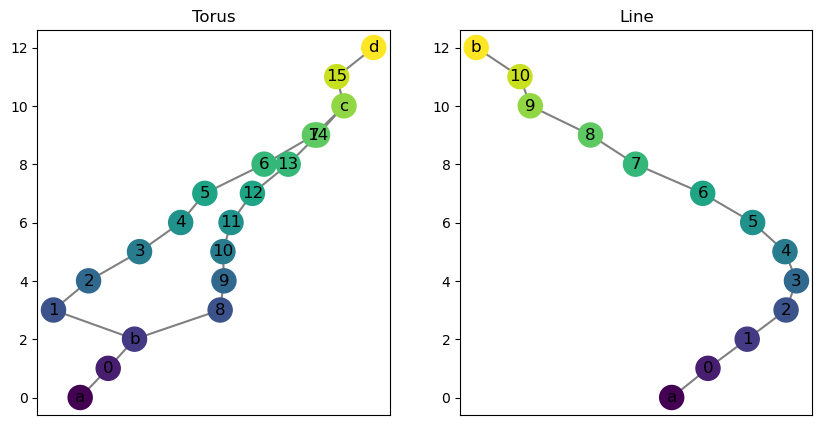

In [25]:
T = ex_mg.torus(0, 2, 10, 12, delta = 1, seed = 17)
L = ex_mg.line(0, 12)

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey = True)
T.draw(ax = ax[0])
ax[0].set_title("Torus")
L.draw(ax = ax[1])
ax[1].set_title("Line");

As before, we can initialize the interleaving. We also ask for randomly generated maps $\varphi: F \to G^n$ and $\psi: G \to F^n$. Note the default is `True`, so if set to `False` this would initialize matrices of the correct structure but filled with zeros.

In [26]:
myAssgn_TL = Assignment(L,T, 
                    initialize_random_maps = True, 
                    seed = 0)

Let's draw all the relevant graphs just to be able to look at what's going on here. 

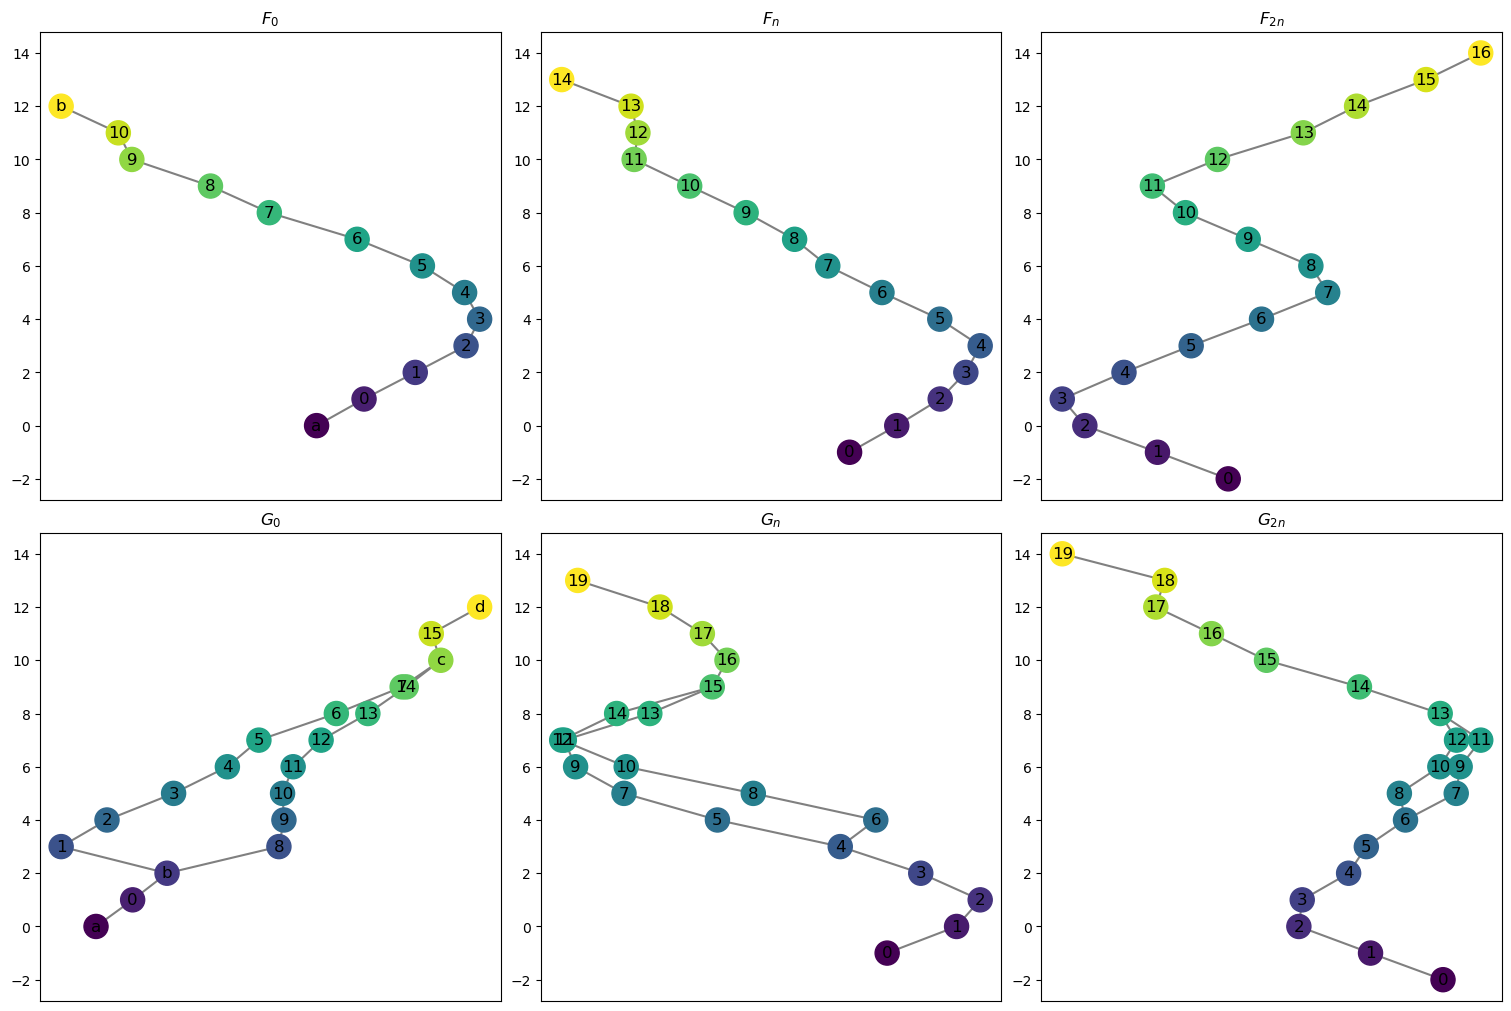

In [27]:
myAssgn_TL.draw_all_graphs();

These can be accessed using the `.phi` and `.psi` functions. As before, these are stored as `LabeledBlockMatrix` types. Note that in the example of a line and torus, the `psi` map has only one possible vertex for the image of any vertex or edge so the matrices are relatively simple. The choice comes with the `phi` map which has two options for image for the middle collection of vertices and edges.

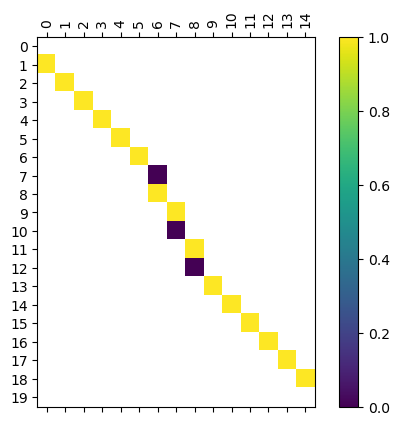

In [28]:
myAssgn_TL.phi('n','V').draw(filltype = 'nan', 
                         colorbar = True, )

We have a command to draw all the matrices at once for ease of visualization. 

(<Figure size 1000x1000 with 8 Axes>,
 array([[<Axes: title={'center': '$\\varphi_0^V$'}, xlabel='V(F)', ylabel='V(G_n)'>,
         <Axes: title={'center': '$\\varphi_n^V$'}, xlabel='V(F_n)', ylabel='V(G_2n)'>],
        [<Axes: title={'center': '$\\varphi_0^E$'}, xlabel='E(F)', ylabel='E(G_n)'>,
         <Axes: title={'center': '$\\varphi_n^E$'}, xlabel='E(F_n)', ylabel='E(G_2n)'>]],
       dtype=object))

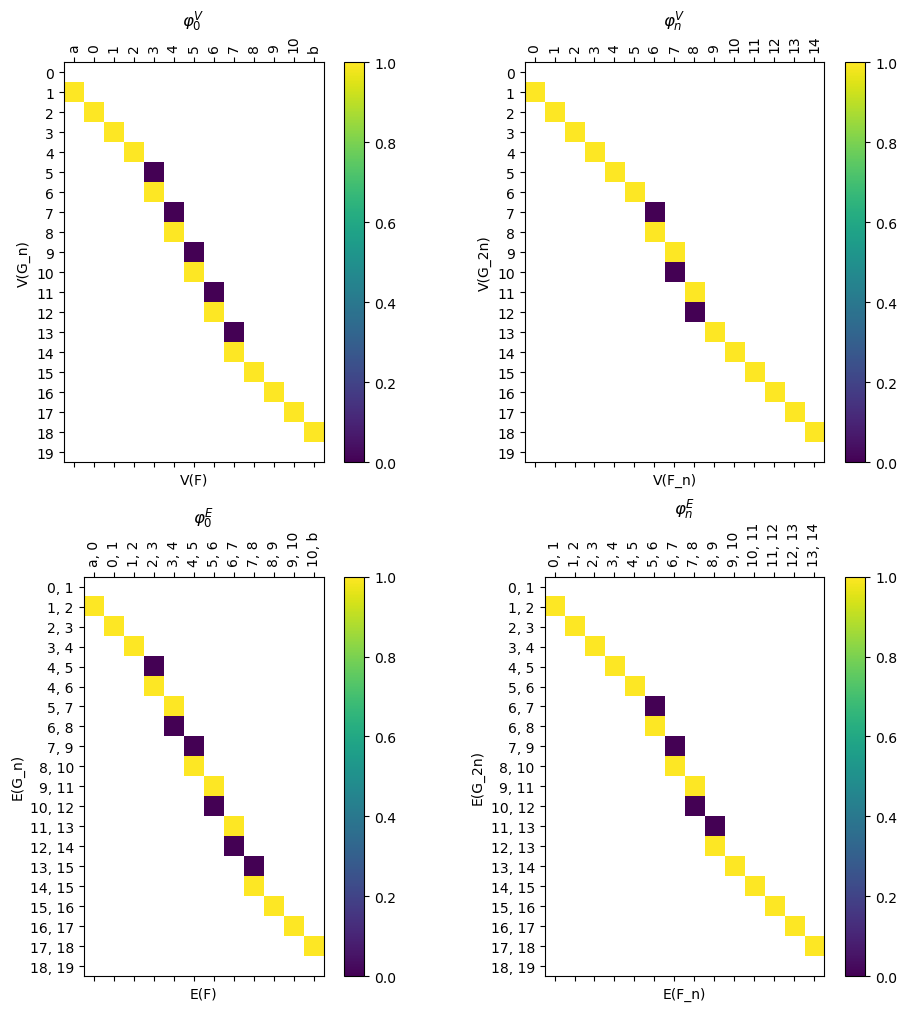

In [29]:
myAssgn_TL.draw_all_phi(filltype = 'nan', colorbar = True)

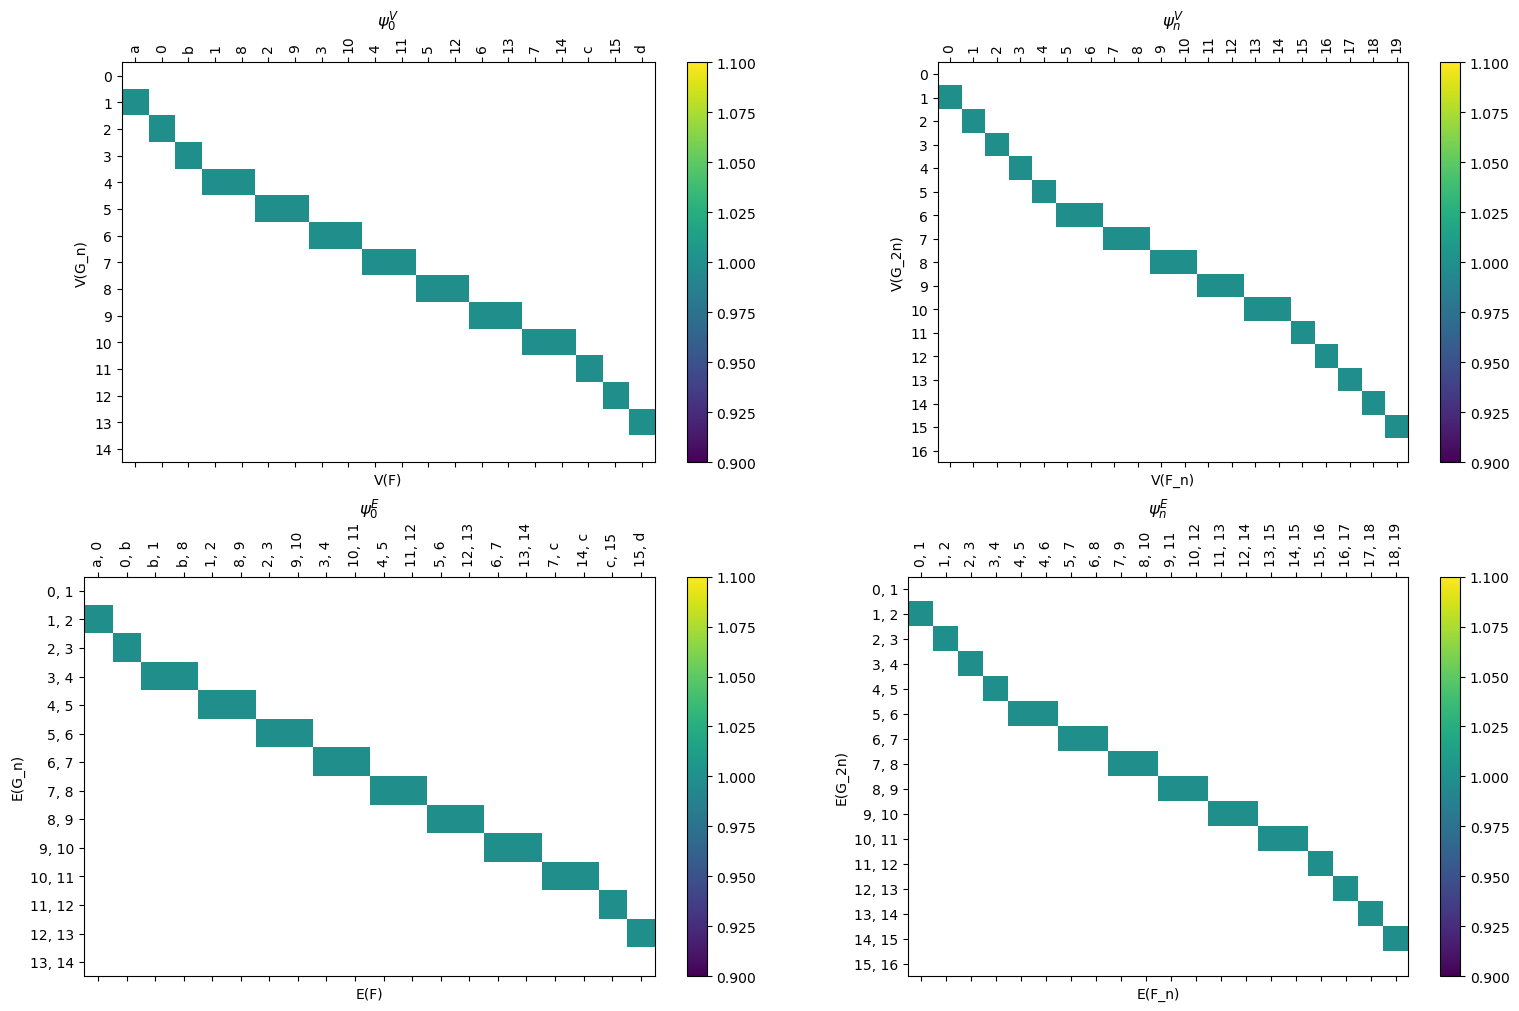

In [30]:
myAssgn_TL.draw_all_psi(figsize = (15,10), colorbar = True, 
                     filltype = 'nan');

### Computing the loss

Our next goal is to determine the loss for the given assignment, where if the loss is $K$ for an $n$-assignment, we know that the interleaving distance for the inputs is $d_I(F,G) \leq n+K$. To do this, we have a giant list of diagrams to check. However, checking these diagrams is reduced to finding maximal entries in products of matrices we've built above. 

The table below shows the diagrams to be checked, following the notation in the paper (**TODO cite paper when it's available!**). In the following sections of the tutorial, we go through each of the three types of diagrams. 

![The list of diagrams and relevant matrix multiplications](../images/TheList.png)

Spoiler alert, the loss for the input assignment can be easily checked with the `.loss` function

In [31]:
myAssgn_TL.loss(verbose = True)

       Dgm Type Req A Req B  Loss
0   Edge-Vertex   phi    up   2.0
1   Edge-Vertex   phi  down   3.0
2   Edge-Vertex   psi    up   0.0
3   Edge-Vertex   psi  down   0.0
4    Thickening   phi     V   2.0
5    Thickening   phi     E   1.0
6    Thickening   psi     V   0.0
7    Thickening   psi     E   0.0
8      Triangle     V     F   0.0
9      Triangle     V     G   1.0
10     Triangle     E     F   0.0
11     Triangle     E     G   1.0

Loss: 3.0
Interleaving distance bound: 1 + 3.0 = 4.0


3.0

However, in the following sections, we show the code to compute each type of diagram loss that goes into the calculation above. 

#### Parallelograms - Edge vertex

Internally, the code multiplies all the relevant matrices together and returns the product with the `myAssgn.paralellogram_Edge_Vert_matrix` command. 

In [32]:
M = myAssgn_TL.parallelogram_Edge_Vert_matrix(maptype = 'phi')
type(M)

cereeberus.distance.labeled_blocks.LabeledBlockMatrix

However, as it is helpful for debugging and visualization, we can draw all the relevant matrices with the same command using the `draw = True` flag. 

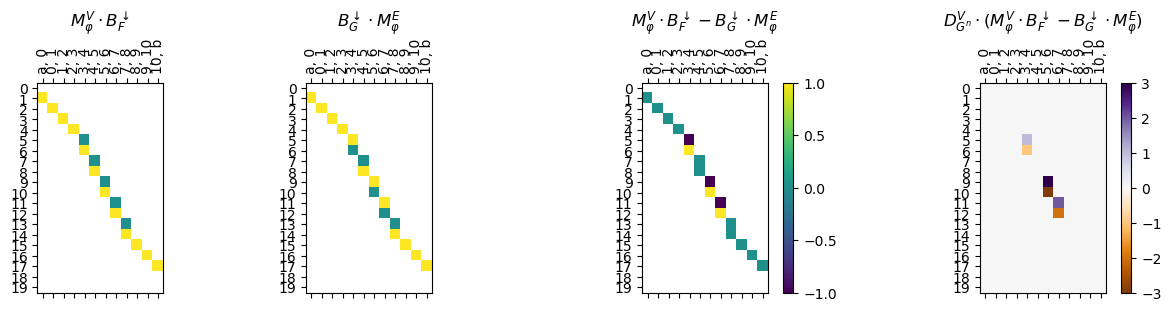

In [33]:
myAssgn_TL.parallelogram_Edge_Vert_matrix(maptype = 'phi', draw = True);

Finally, if we just want the loss value for this diagram type, we have the `.parallelograpm_Edge_Vert` command. The loss value computed is the maximum value in the multiplied matrix. 

In [34]:
result = myAssgn_TL.parallelogram_Edge_Vert(maptype = 'phi')
print(f"Maximum loss value for phi edge-vertex parallelogram: {result}")

Maximum loss value for phi edge-vertex parallelogram: 3.0


If we need the loss by function value level, we can also pass in the value we care about. 

In [35]:
result = myAssgn_TL.parallelogram_Edge_Vert(maptype='phi', up_or_down='up', func_val= 5)
print(f"Maximum loss value for phi edge-vertex\nparallelogram at function value {5}: {result}")

Maximum loss value for phi edge-vertex
parallelogram at function value 5: 0.0


#### Parallelograms - Thickening 

The version of computing the parallelogram loss for the thickening type of diagrams has a similar structure to the edge-vertex version. The main difference is that we have a choice of object type (either vertices or edges). However, the loss value returned is still the maximum value in the multiplied matrix. 

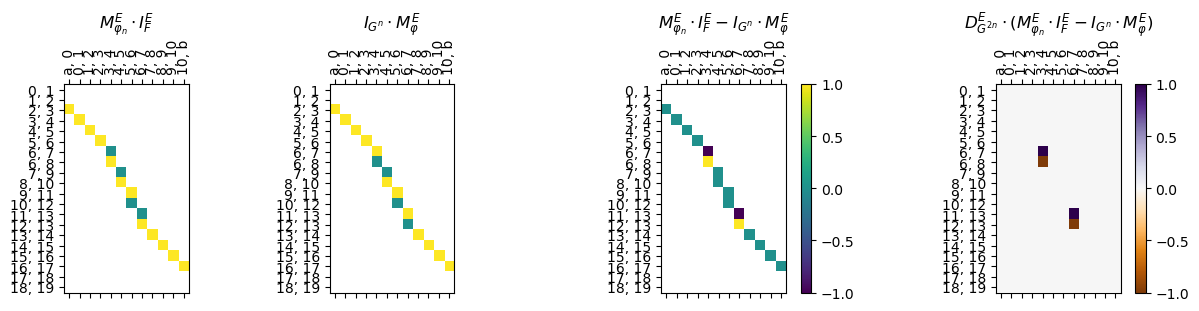

In [36]:
myAssgn_TL.parallelogram_matrix(maptype = 'phi', 
                                obj_type = 'E', 
                                draw = True);

In [37]:
result = myAssgn_TL.parallelogram(maptype = 'phi', obj_type = 'E', )
print(f"Maximum loss value for thickening paralellogram for edges: {result}")

Maximum loss value for thickening paralellogram for edges: 1.0


And as before, we can also compute the loss by each function value.

In [38]:
result = myAssgn_TL.parallelogram(maptype='phi', obj_type='E', func_val=5)
print(f"Maximum loss value for edges at function value {5}: {result}")

Maximum loss value for edges at function value 5: 0.0


#### Triangles
Finally, the triangle diagrams are the ones that ensure that the assignment forms an interleaving. Note that the loss function computed is $\lceil \frac{k}{2} \rceil$ for $k$ the maximum absolute value in the multiplied matrix. 


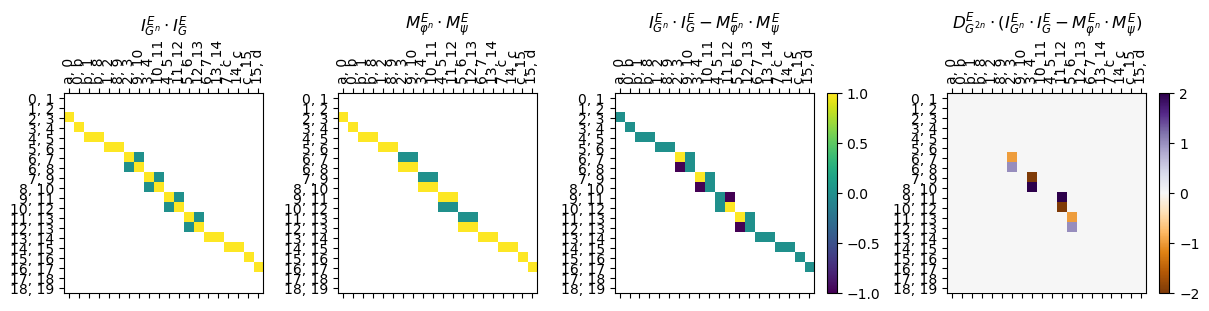

In [39]:
myAssgn_TL.triangle_matrix(start_graph = 'G', obj_type = 'E', draw = True);

In [40]:
myAssgn_TL.triangle(start_graph = 'G', obj_type = 'E');
print(f"Maximum loss value for triangle: {result}")

Maximum loss value for triangle: 0.0


We can also compute the loss by each function value

In [41]:
result = myAssgn_TL.triangle(start_graph = 'G', obj_type = 'V', func_val=5)
print(f"Maximum loss value for vertices at function value {5}: {result}")

Maximum loss value for vertices at function value 5: 1.0


In [42]:
results = myAssgn_TL.triangle(start_graph = 'G', obj_type = 'E')
print(f"Maximum loss value for triangle: {results}")

Maximum loss value for triangle: 1.0


### The loss computation for fixed assignment input 

We do not need all the visuals above, the loss function for a fixed input assignment can be computed as follows. Note that the actual distance between a line and a torus graph with loop height $h$ is $\lceil \frac{h}{4}\rceil$, so in this case the actual distance $d_I(T,L) =\lceil \frac{8}{4}\rceil = 2$.  

In [43]:
myAssgn_TL.loss(verbose = True)

       Dgm Type Req A Req B  Loss
0   Edge-Vertex   phi    up   2.0
1   Edge-Vertex   phi  down   3.0
2   Edge-Vertex   psi    up   0.0
3   Edge-Vertex   psi  down   0.0
4    Thickening   phi     V   2.0
5    Thickening   phi     E   1.0
6    Thickening   psi     V   0.0
7    Thickening   psi     E   0.0
8      Triangle     V     F   0.0
9      Triangle     V     G   1.0
10     Triangle     E     F   0.0
11     Triangle     E     G   1.0

Loss: 3.0
Interleaving distance bound: 1 + 3.0 = 4.0


3.0

Finally, if we want to use the internal ILP solver to find an optimal interleaving, we use the `.optimize` command. 

In [44]:
loss_optimized = myAssgn_TL.optimize()
print(f"Optimized loss value: {loss_optimized}")
print(f"Bound for interleaving: {loss_optimized + myAssgn_TL.n}")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/lm/dn75vz_d72b1cntn3ncjj10c0000gn/T/800ce1f5a1584d68b6e64e5d55a266de-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/lm/dn75vz_d72b1cntn3ncjj10c0000gn/T/800ce1f5a1584d68b6e64e5d55a266de-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 992 COLUMNS
At line 3370 RHS
At line 4358 BOUNDS
At line 4723 ENDATA
Problem MODEL has 987 rows, 364 columns and 1648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.00 seconds
Cgl0003I 0 fixed, 9 tightened bounds, 0 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 8 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 7 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1 s

Note that when we optimize the loss function, we also overwrite the phi and psi with the found assignment internally. 

Loss is now 1.0


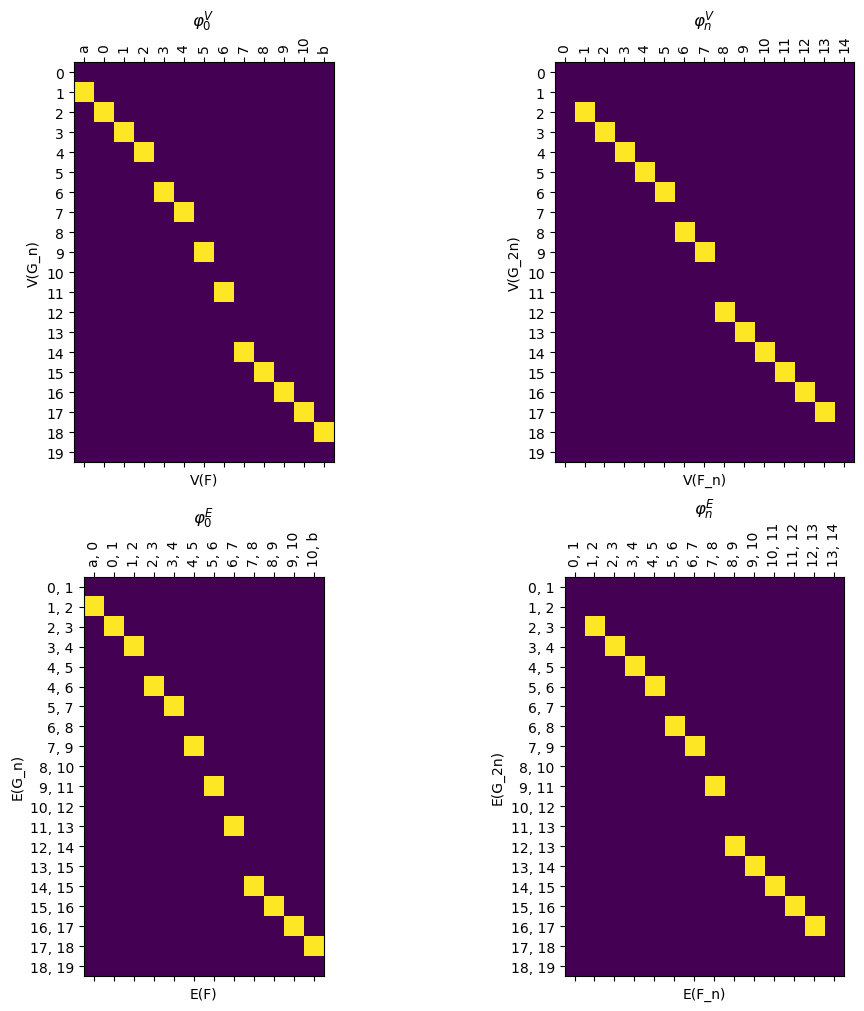

In [45]:
myAssgn_TL.draw_all_phi();
print(f'Loss is now {myAssgn_TL.loss()}')